# Titanic Survival Prediction - Example Notebook

This notebook demonstrates the complete ML workflow for the mlsys project:
1. Load and explore data
2. Perform feature engineering
3. Train and evaluate a classification model
4. Upload trained model to GCS

**Model**: Titanic survival prediction (binary classification)

**Data Source**: sklearn's OpenML Titanic dataset (for demonstration purposes)

**Model Version**: v1

## Setup

Import required libraries and configure environment.

In [ ]:
# Standard library
import json
import warnings
from datetime import UTC, datetime

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# mlsys utilities
from mlsys.gcs import gcs_put, gcs_put_pickle
from mlsys.settings import GCS_BUCKET_MODELS_DEV
from mlsys.vis import setup_plot_style

# Configure
warnings.filterwarnings("ignore")
setup_plot_style()
pd.set_option("display.max_columns", None)

print("Setup complete!")

## 1. Load Data

For this example, we'll use sklearn's Titanic dataset. In production, you would use `bq_get()` to fetch data from BigQuery:

```python
from mlsys.bq import bq_get

df = bq_get("""
    SELECT * 
    FROM `my-project.my_dataset.titanic_training`
    WHERE date >= '2024-01-01'
""")
```

In [ ]:
# Load Titanic dataset from sklearn
titanic = fetch_openml("titanic", version=1, as_frame=True, parser="auto")
df = titanic.frame

## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Overview

In [ ]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   survived   1309 non-null   category
 2   name       1309 non-null   object  
 3   sex        1309 non-null   category
 4   age        1046 non-null   float64 
 5   sibsp      1309 non-null   int64   
 6   parch      1309 non-null   int64   
 7   ticket     1309 non-null   object  
 8   fare       1308 non-null   float64 
 9   cabin      295 non-null    object  
 10  embarked   1307 non-null   category
 11  boat       486 non-null    object  
 12  body       121 non-null    float64 
 13  home.dest  745 non-null    object  
dtypes: category(3), float64(3), int64(3), object(5)
memory usage: 116.8+ KB
None


,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [ ]:
df.isna().mean().to_frame()

,0
pclass,0.000000
survived,0.000000
name,0.000000
sex,0.000000
age,0.200917
sibsp,0.000000
parch,0.000000
ticket,0.000000
fare,0.000764
cabin,0.774637


In [ ]:
# Missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({"Count": missing, "Percentage": missing_pct})
missing_df[missing_df["Count"] > 0].sort_values("Count", ascending=False)

Missing Values:


,Count,Percentage
body,1188,90.756303
cabin,1014,77.463713
boat,823,62.872422
home.dest,564,43.086325
age,263,20.091673
embarked,2,0.152788
fare,1,0.076394


### 2.2 Target Variable Distribution

Survival Counts:
survived
0    809
1    500
Name: count, dtype: int64

Survival Rate: 38.20%


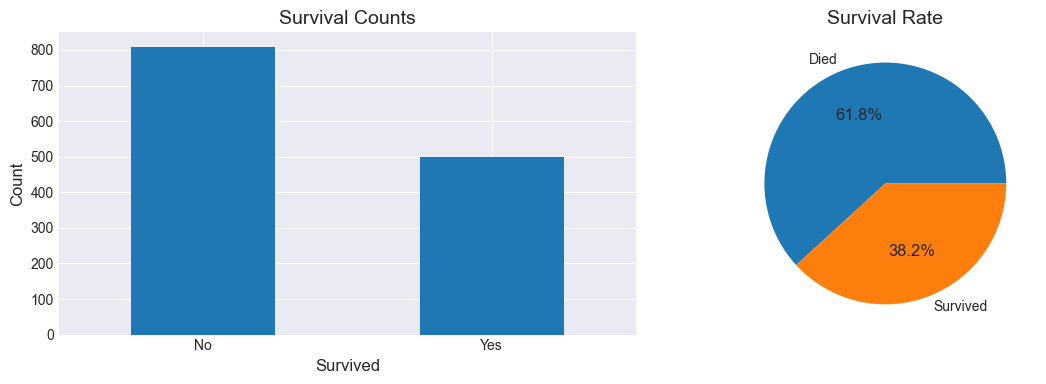

In [ ]:
# Survival distribution
survival_counts = df["survived"].value_counts()
print("Survival Counts:")
print(survival_counts)
print(f"\nSurvival Rate: {(survival_counts[1] / len(df)) * 100:.2f}%")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

survival_counts.plot(kind="bar", ax=ax[0])
ax[0].set_title("Survival Counts")
ax[0].set_xlabel("Survived")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(["No", "Yes"], rotation=0)

survival_counts.plot(kind="pie", autopct="%1.1f%%", ax=ax[1], labels=["Died", "Survived"])
ax[1].set_title("Survival Rate")
ax[1].set_ylabel("")

plt.tight_layout()
plt.show()

### 2.3 Feature Analysis

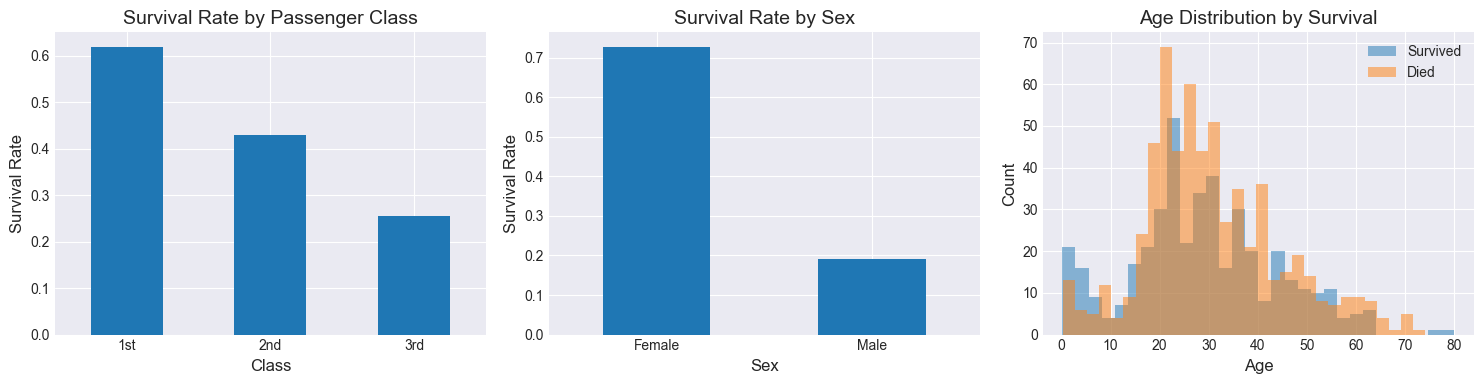

In [ ]:
# Survival by passenger class
survival_by_class = df.groupby("pclass")["survived"].apply(lambda x: (x == "1").mean())

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# By class
survival_by_class.plot(kind="bar", ax=ax[0])
ax[0].set_title("Survival Rate by Passenger Class")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Survival Rate")
ax[0].set_xticklabels(["1st", "2nd", "3rd"], rotation=0)

# By sex
survival_by_sex = df.groupby("sex")["survived"].apply(lambda x: (x == "1").mean())
survival_by_sex.plot(kind="bar", ax=ax[1])
ax[1].set_title("Survival Rate by Sex")
ax[1].set_xlabel("Sex")
ax[1].set_ylabel("Survival Rate")
ax[1].set_xticklabels(["Female", "Male"], rotation=0)

# Age distribution by survival
df[df["survived"] == "1"]["age"].hist(bins=30, alpha=0.5, label="Survived", ax=ax[2])
df[df["survived"] == "0"]["age"].hist(bins=30, alpha=0.5, label="Died", ax=ax[2])
ax[2].set_title("Age Distribution by Survival")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Count")
ax[2].legend()

plt.tight_layout()
plt.show()

## 3. Train/Test Split

In [ ]:
feature_cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
numeric_features = ["Age", "Fare", "SibSp", "Parch"]
categorical_features = ["Sex", "Pclass"]

# Create feature matrix and target
X = df[feature_cols].copy()
y = df["Survived"].astype(int)

print(f"X shape: {X.shape}, y shape: {y.shape}")

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: (1047, 6)
Test set size: (262, 6)

Target distribution in training set:
survived
0    0.617956
1    0.382044
Name: proportion, dtype: float64


## 4. Model Training

Train a Random Forest classifier.

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create full pipeline with classifier
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=100, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1
            ),
        ),
    ]
)

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


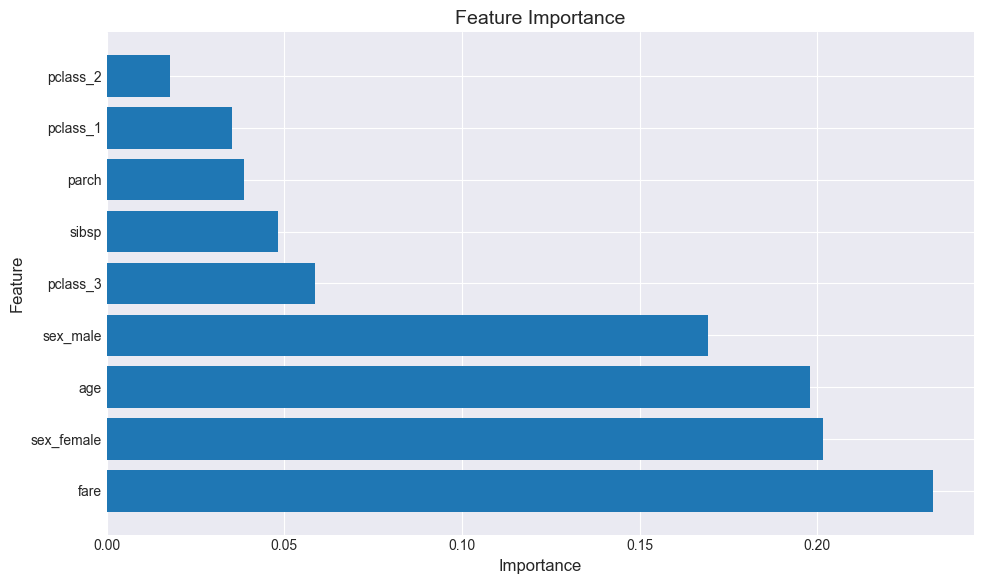

In [ ]:
# Feature importance (fix for sklearn pipeline)
importances = model.named_steps["classifier"].feature_importances_
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)
feature_importance = pd.DataFrame({"feature": all_features, "importance": importances}).sort_values(
    "importance", ascending=False
)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

## 5. Model Evaluation

Evaluate model performance on the test set.

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Died", "Survived"]))

Test Accuracy: 0.8244
Test ROC AUC: 0.8934

Classification Report:
              precision    recall  f1-score   support

        Died       0.83      0.90      0.86       162
    Survived       0.81      0.70      0.75       100

    accuracy                           0.82       262
   macro avg       0.82      0.80      0.81       262
weighted avg       0.82      0.82      0.82       262



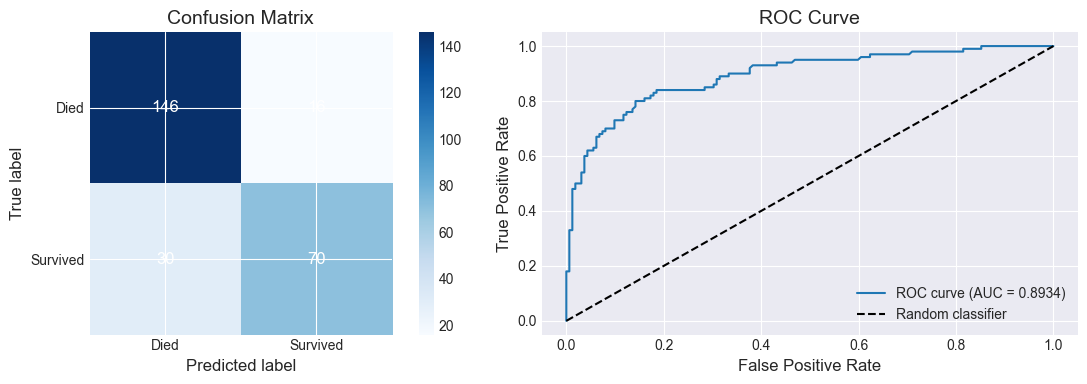

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Confusion matrix
im = ax[0].imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax[0].figure.colorbar(im, ax=ax[0])
ax[0].set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=["Died", "Survived"],
    yticklabels=["Died", "Survived"],
    title="Confusion Matrix",
    ylabel="True label",
    xlabel="Predicted label",
)

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax[1].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Random classifier")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC Curve")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Upload Model to GCS

Save the trained model and scaler to Google Cloud Storage for deployment.

**Model artifacts**:
- `model.pkl`: Trained RandomForest classifier
- `scaler.pkl`: StandardScaler fitted on training data

**GCS path**: `gs://ml-models-dev/titanic-survival/v1/`

In [ ]:
# Define model metadata
MODEL_NAME = "titanic-survival"
MODEL_VERSION = "v2"
BUCKET_NAME = GCS_BUCKET_MODELS_DEV

print(f"Model: {MODEL_NAME}")
print(f"Version: {MODEL_VERSION}")
print(f"Bucket: {BUCKET_NAME}")

Model: titanic-survival
Version: v2
Bucket: mlsys-models-dev


In [ ]:
# Upload model artifact
model_path = f"{MODEL_NAME}/{MODEL_VERSION}/model.pkl"
print(f"Uploading model to gs://{BUCKET_NAME}/{model_path}")

gcs_put_pickle(obj=model, bucket_name=BUCKET_NAME, blob_path=model_path)
print("Model uploaded successfully!")

## 7. Model Metadata

Document model metadata for tracking and reproducibility.

In [ ]:
# Model metadata
metadata = {
    "model_name": MODEL_NAME,
    "model_version": MODEL_VERSION,
    "model_type": "RandomForestClassifier",
    "training_date": datetime.now(UTC).isoformat(),
    "features": list(X.columns),
    "target": "Survived",
    "training_samples": len(X_train),
    "test_samples": len(X_test),
    "test_accuracy": float(accuracy),
    "test_roc_auc": float(roc_auc),
    "hyperparameters": {
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 5,
        "random_state": 42,
    },
    "gcs_path": f"gs://{BUCKET_NAME}/{MODEL_NAME}/{MODEL_VERSION}/",
}

print("Model Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

In [ ]:
# Save metadata to GCS
metadata_path = f"{MODEL_NAME}/{MODEL_VERSION}/metadata.json"
print(f"Uploading metadata to gs://{BUCKET_NAME}/{metadata_path}")

gcs_put(content=json.dumps(metadata, indent=2), bucket_name=BUCKET_NAME, blob_path=metadata_path)
print("Metadata uploaded successfully!")

## Summary

### Model Performance
- **Test Accuracy**: {accuracy:.4f}
- **Test ROC AUC**: {roc_auc:.4f}
- **CV ROC AUC**: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})

### Artifacts Uploaded to GCS
1. **Model**: `gs://ml-models-dev/titanic-survival/v1/model.pkl`
2. **Scaler**: `gs://ml-models-dev/titanic-survival/v1/scaler.pkl`
3. **Metadata**: `gs://ml-models-dev/titanic-survival/v1/metadata.json`

### Next Steps
1. Create an Airflow DAG to schedule predictions
2. Deploy to Cloud Run for production
3. Monitor model performance over time
4. Iterate on features and hyperparameters for improved performance